# ARIM-Academy：　機器データ利活用ユースケース
### タイトル：機械学習支援によるプロセス設計：限られた実験データを用いたマイクロ波アシスト型アンモニア合成
### 機器：マイクロ波合成装置（ガス反応）
### 分析：ANN（人口ニューラルネットワーク）による合成反応予測モデルの構築（４変数）

---
### 本コードの目標  

本演習では、**SMOTE (Synthetic Minority Over-sampling Technique)** を用いて実験パラメータが４つの場合における機械学習モデルを行います。 

---

【1】Masud MAA, Araia A, Wang Y, Hu J, Tian Y. Machine learning-aided process design using limited experimental data: A microwave-assisted ammonia synthesis case study. *AIChE Journal*. 2024; e18621. doi:10.1002/aic.18621  

### コードへの接続
google colabにおけるオンラインの場合にこのラインを実行します。（<font color="red">Google colabに接続しない場合には不要</font>）

In [ ]:
!pip install pip install imbalanced-learn
!git clone https://github.com/ARIM_ProcessInformatics/Example_1.git
%cd Example_1

### ライブラリのインポート
コード実行で必要なpythonのライブラリをimport文でロードします。

In [1]:
# 汎用ライブラリ
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

# SMOTE
from imblearn.over_sampling import SMOTE

# 機械学習モデル
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')

# 1. データの準備
### サンプルファイルの読み込み
ここでは[data]フォルダーにあるdata_full.csvファイルをDataFrameとして読み込み、その結果をdfという変数に格納します。

In [2]:
# CSVファイルからデータを読み込む
df = pd.read_csv('./data/data_full.csv')
df

,Temperature(C),Pressure(psig),H2 to N2 ratio,Flow rate(ml/g),Ammonia Concentration(%)
0,320.00,0.00,0.5,100.0,0.36
1,320.00,20.49,0.5,100.0,0.69
2,320.00,39.18,0.5,100.0,0.96
3,320.00,59.59,0.5,100.0,1.21
4,320.00,79.93,0.5,100.0,1.43
5,320.00,0.00,1.0,100.0,0.58
6,320.00,10.24,1.0,100.0,0.79
7,320.00,20.11,1.0,100.0,0.96
8,320.00,39.33,1.0,100.0,1.23
9,320.00,59.44,1.0,100.0,1.44


In [3]:
# 特徴量とラベルの列名を取得
fea_columns = df.columns[1:5]
labels = df.columns[5:]

### 重複データの削減
重複行をdrop_duplicates()メソッドを使って削除し、data_delに格納します。

In [4]:
# 重複を削除したデータフレームを作成
data_del = df.drop_duplicates(subset=fea_columns, keep='first')
ind_set = list(itertools.combinations(range(data_del.shape[0]), 3))

# 2. SMOTEによるデータ生成

In [5]:
# SMOTEによるデータ生成
smote = SMOTE(k_neighbors=1, random_state=0)

### データ拡張

In [6]:
# SMOTEを用いてデータ拡張を実行
smote_data = []

for item in ind_set:
    indices = list(item)
    y_smote = np.zeros(data_del.shape[0])
    y_smote[indices] = 1
    data_resampled, _ = smote.fit_resample(data_del, y_smote)
    smote_data.append(data_resampled)

In [7]:
# リストをNumPy配列に変換し、ユニークなデータポイントを抽出
smote_data = np.array(smote_data).reshape(-1, 5)
smote_data

array([[3.20000000e+02, 0.00000000e+00, 5.00000000e-01, 1.00000000e+02,
        3.60000000e-01],
       [3.20000000e+02, 2.04900000e+01, 5.00000000e-01, 1.00000000e+02,
        6.90000000e-01],
       [3.20000000e+02, 3.91800000e+01, 5.00000000e-01, 1.00000000e+02,
        9.60000000e-01],
       ...,
       [3.46731581e+02, 8.00000000e+01, 1.00000000e+00, 5.00000000e+01,
        1.68263934e+00],
       [3.42966258e+02, 8.00000000e+01, 1.00000000e+00, 5.00000000e+01,
        1.70565711e+00],
       [3.63438817e+02, 8.00000000e+01, 1.00000000e+00, 5.00000000e+01,
        1.57710593e+00]])

In [8]:
smote_data.shape

(2342600, 5)

### データ選択

In [9]:
unique_data_array, unique_indices = np.unique(smote_data, axis=0, return_index=True)
unique_data_array

array([[280.25      ,  80.        ,   1.        ,  50.        ,
          1.21      ],
       [280.25      ,  80.        ,   1.        ,  50.70506485,
          1.20576961],
       [280.25      ,  80.        ,   1.        ,  52.03574534,
          1.19778553],
       ...,
       [401.24      ,  80.        ,   1.        , 198.64283644,
          1.09203575],
       [401.24      ,  80.        ,   1.        , 199.52995677,
          1.09070506],
       [401.24      ,  80.        ,   1.        , 200.        ,
          1.09      ]])

In [10]:
unique_data_array.shape

(69415, 5)

In [11]:
# 23000件のランダムなユニークデータポイントを選択
np.random.seed(42)
random_unique_indices = np.random.choice(unique_data_array.shape[0], size=23000, replace=False)
unique_data_random = unique_data_array[random_unique_indices]

# 重複データを抽出し、元データと結合
smote_data_array = np.vstack((unique_data_random, df.values))
print(f"Shape of combined data: {smote_data_array.shape}")

Shape of combined data: (23053, 5)


# 3. 機械学習モデルの適用

### データセットの分割（Data set splitting）

In [12]:
# 特徴量とラベルを分割
X = smote_data_array[:, :4]
y = smote_data_array[:, -1]

### Kerasによるモデル構築
人工ニューラルネットワーク（ANN）で4変数をインプットデータとするモデルを構成します。

In [13]:
# モデルの構築
model = Sequential([
    Input(shape=(4,)),  # 入力形状を指定
    Dense(64, activation='softplus'),
    Dense(128, activation='softplus'),
    Dense(64, activation='softplus'),
    Dense(1, activation='linear')
])

### モデルの設定と実行
ここの設定は2と変更はありません。

In [14]:
model.compile(loss='mse', optimizer=Adam(learning_rate=0.0001))
model.fit(X, y, epochs=100, batch_size=3)

Epoch 1/100
7685/7685 ━━━━━━━━━━━━━━━━━━━━ 7s 812us/step - loss: 31.3681
Epoch 2/100
7685/7685 ━━━━━━━━━━━━━━━━━━━━ 7s 887us/step - loss: 0.0866
Epoch 3/100
7685/7685 ━━━━━━━━━━━━━━━━━━━━ 7s 942us/step - loss: 0.0696
Epoch 4/100
7685/7685 ━━━━━━━━━━━━━━━━━━━━ 7s 972us/step - loss: 0.0562
Epoch 5/100
7685/7685 ━━━━━━━━━━━━━━━━━━━━ 8s 998us/step - loss: 0.0487
Epoch 6/100
7685/7685 ━━━━━━━━━━━━━━━━━━━━ 7s 953us/step - loss: 0.0455
Epoch 7/100
7685/7685 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.0412
Epoch 8/100
7685/7685 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.0377
Epoch 9/100
7685/7685 ━━━━━━━━━━━━━━━━━━━━ 34s 4ms/step - loss: 0.0346
Epoch 10/100
7685/7685 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 0.0333
Epoch 11/100
7685/7685 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.0293
Epoch 12/100
7685/7685 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.0287
Epoch 13/100
7685/7685 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.0282
Epoch 14/100
7685/7685 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.02

# 4.予測モデル
予測と実測のアンモニア濃度が圧力や温度でどのように変化するかをプロットします。

In [15]:
# 定数
Temperature = 320
Pressure = 80
Gas_flow_rate = 100
Ratio = 1

Pressure_range = range(0, 81, 1)
Temperature_range = range(280, 400, 1)

Ratio_Exp_values = [0.5, 1, 2, 3, 5]
Gas_flow_rates = [100, 200, 250, 50]

# 圧力に対するプロット
scatter_data = [
    [0.4, 0.63, 0.99, 1.41],
    [0.57, 0.95, 1.24, 1.43, 1.55, 1.57],
    [0.6, 0.96, 1.16, 1.27, 1.33, 1.35],
    [0.56, 0.85, 0.89, 1.06],
    [0.48, 0.63, 0.63, 0.69]
]

### 圧力依存性プロット¶

In [16]:
# モデル予測とプロットの関数
def plot_predict_pressure(temperature, gas_flow, ratio, exp_points):

    pressures = np.arange(0, 81, 1)
    inputs = np.array([[temperature, p, ratio, gas_flow] for p in pressures])
    
    predictions = model.predict(inputs)

    plt.plot(pressures, predictions, label=f'Ratio={ratio}')
    plt.scatter(*zip(*exp_points))

    plt.xlabel('Pressure(psig)')
    plt.ylabel('NH3 concentration(%)')
    plt.legend()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


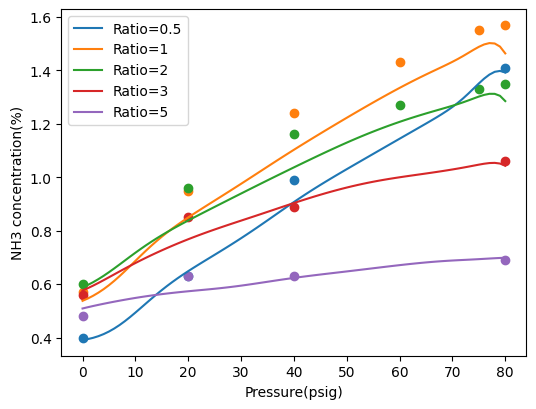

In [17]:
# プロットサイズを指定
plt.figure(figsize=(6, 4.5))

# 各水素：窒素比でのプロット
plot_predict_pressure(Temperature, Gas_flow_rate, 0.5, [(0, 0.4), (20, 0.63), (40, 0.99), (80, 1.41)])
plot_predict_pressure(Temperature, Gas_flow_rate, 1, [(0, 0.57), (20, 0.95), (40, 1.24), (60, 1.43), (75, 1.55), (80, 1.57)])
plot_predict_pressure(Temperature, Gas_flow_rate, 2, [(0, 0.6), (20, 0.96), (40, 1.16), (60, 1.27), (75, 1.33), (80, 1.35)])
plot_predict_pressure(Temperature, Gas_flow_rate, 3, [(0, 0.56), (20, 0.85), (40, 0.89), (80, 1.06)])
plot_predict_pressure(Temperature, Gas_flow_rate, 5, [(0, 0.48), (20, 0.63), (40, 0.63), (80, 0.69)])

plt.show()

### 温度依存性プロット

In [18]:
# 温度に対するプロット
def predict_plot_temperature(pressure, ratio, gas_flow, exp_points):
    
    temperatures = np.arange(280, 400, 1)
    inputs = np.array([[temp, pressure, ratio, gas_flow] for temp in temperatures])  # NumPy配列に変換
    
    predictions = model.predict(inputs)

    plt.plot(temperatures, predictions, label=f'Flow rate = {gas_flow*60} ml/h.gcat')
    plt.scatter(*zip(*exp_points))
    
    plt.xlabel('Temperature (C)')
    plt.ylabel('NH3 concentration (%)')
    plt.legend()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


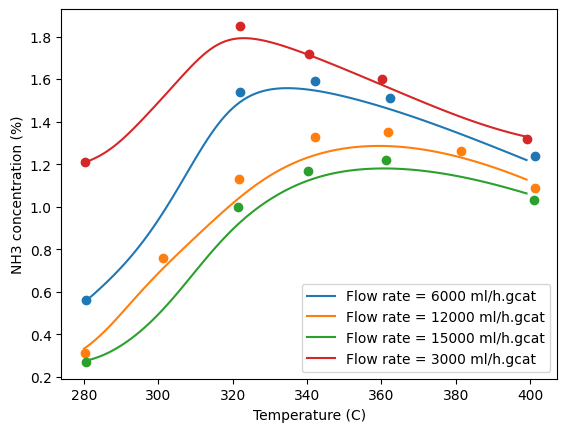

In [19]:
# 各水素：窒素比でのプロット
predict_plot_temperature(Pressure, Ratio, 100, [(280.5, 0.56), (321.99, 1.54), (342.11, 1.59), (362.24, 1.51),(401.24, 1.24)])
predict_plot_temperature(Pressure, Ratio, 200, [(280.25, 0.31), (301.37, 0.76), (321.74, 1.13), (342.11, 1.33), (361.74, 1.35), (381.37, 1.26),(401.24, 1.09)])
predict_plot_temperature(Pressure, Ratio, 250, [(280.5, 0.27), (321.49, 1), (340.12, 1.17), (361.24, 1.22), (400.99, 1.03)])
predict_plot_temperature(Pressure, Ratio, 50, [(280.25, 1.21), (321.99, 1.85), (340.62, 1.72), (360.25, 1.60),(399.25, 1.32)])

### 個別パラメータにおける依存性

In [25]:
# プロット作成関数
def generate_plot(input_data, x_column_index, xlabel, ylabel, title, figure_num):
    # リストをNumPy配列に変換
    try:
        input_data = np.array(input_data)
    except ValueError as e:
        print("Error converting to np.array:", e)
        print("Sample of input_data:", input_data[:5])  # デバッグ用に最初の5つを表示
        return
    
    # 予測
    z_pred = model.predict(input_data)
    
    # 指定されたカラムインデックスに基づいてX軸の値を抽出
    x_vals = input_data[:, x_column_index]
    
    # プロット
    plt.figure(figure_num)
    plt.plot(x_vals, z_pred, label=title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()

#### 圧力依存性

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


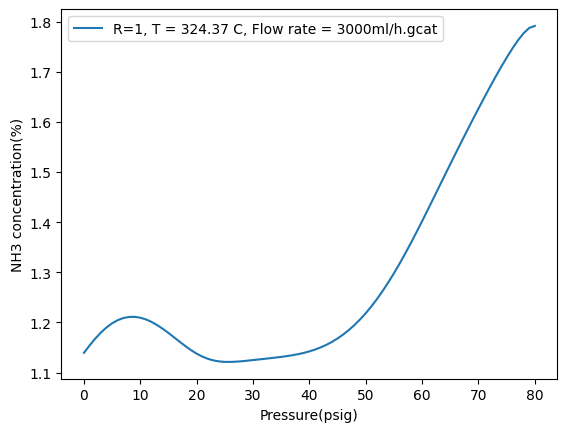

In [21]:
# 1st plot
Temperature = 324.37
Pressure_range = range(0, 81, 1)
Gas_flow_rate = 50
Ratio_exp = 1

Combined_array = [[Temperature, p, Ratio_exp, Gas_flow_rate] for p in Pressure_range]

generate_plot(
    Combined_array,
    x_column_index=1,  # Pressure列を指定
    xlabel='Pressure(psig)',
    ylabel='NH3 concentration(%)',
    title='R=1, T = 324.37 C, Flow rate = 3000ml/h.gcat',
    figure_num=3
)

#### 温度依存性

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


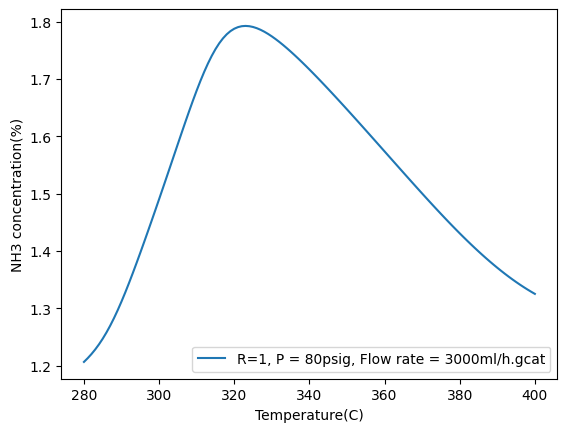

In [22]:
# 2nd plot
Temperature_range = range(280, 401, 1)
Pressure = 80
Ratio_exp = 1
Gas_flow_rate = 50

Combined_array = [[t, Pressure, Ratio_exp, Gas_flow_rate] for t in Temperature_range]

generate_plot(
    Combined_array,
    x_column_index=0,  # Temperature列を指定
    xlabel='Temperature(C)',
    ylabel='NH3 concentration(%)',
    title='R=1, P = 80psig, Flow rate = 3000ml/h.gcat',
    figure_num=4
)

#### 水素-窒素比依存性

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


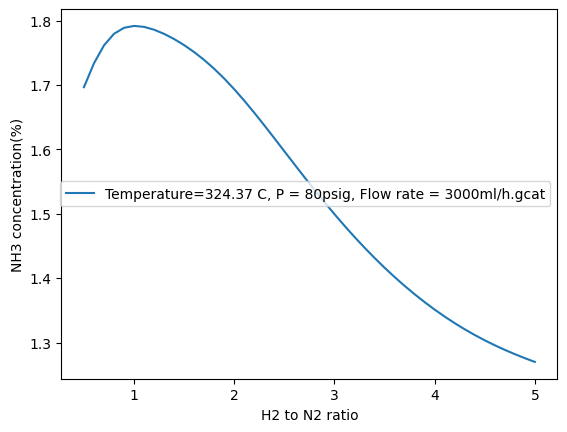

In [23]:
# 3rd plot

Temperature = 324.37
Pressure = 80
num_elements = int((5 - 0.50) / 0.1) + 1
Ratio_exp = np.linspace(0.50, 5, num_elements)
Gas_flow_rate = 50

Combined_array = [[Temperature, Pressure, r, Gas_flow_rate] for r in Ratio_exp]

generate_plot(
    Combined_array,
    x_column_index=2,  # H2 to N2 ratio列を指定
    xlabel='H2 to N2 ratio',
    ylabel='NH3 concentration(%)',
    title='Temperature=324.37 C, P = 80psig, Flow rate = 3000ml/h.gcat',
    figure_num=5
)

#### ガス流動速度の依存性

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


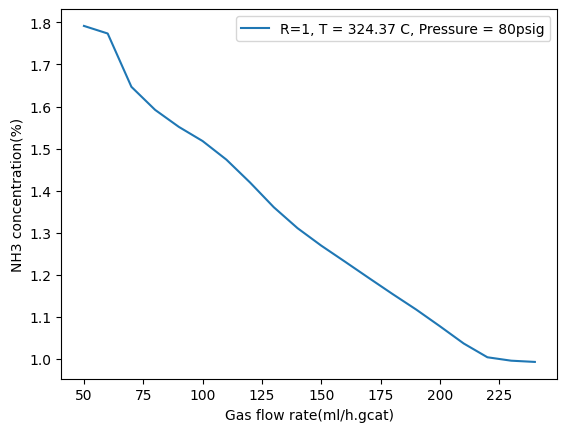

In [24]:
# 4th plot
Temperature = 324.37
Pressure = 80
Ratio_exp = 1
Gas_flow_range = range(50, 250, 10)

Combined_array = [[Temperature, Pressure, Ratio_exp, gf] for gf in Gas_flow_range]

generate_plot(
    Combined_array,
    x_column_index=3,  # Gas flow rate列を指定
    xlabel='Gas flow rate(ml/h.gcat)',
    ylabel='NH3 concentration(%)',
    title='R=1, T = 324.37 C, Pressure = 80psig',
    figure_num=6
)

### モデルの保存

In [ ]:
# モデルの保存
model.save('./output/my_model.keras')